# Domain-Average Radiation Flux Budgets

We plot the domain-average radiation fluxes (and their components). Simulation is considered relative to observation.

In [1]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import pylab as pl
import xarray as xr

import seaborn as sns

In [2]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 18.0
pl.rcParams['lines.linewidth'] = 3


In [3]:
import nawdex_analysis.io.collector

In [4]:
from  nawdex_analysis.plot.stacked_analysis_plots import hor_barplot_exp_plot


## Collect Data

In [5]:
rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'strict'  )
rset2= nawdex_analysis.io.collector.get_radflux4set( 2 )

rset

<xarray.Dataset>
Dimensions:        (ct: 11, idname: 16, time: 264)
Coordinates:
  * idname         (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct             (ct) |S18 'clear_ocean' 'very low' ... 'fractional'
  * time           (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
Data variables:
    afrac          (time, ct, idname) float64 22.11 21.22 23.02 ... 8.958 8.958
    swf_up_clear   (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_net_clear  (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_down       (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf_clear      (time, ct, idname) float64 276.2 276.4 275.8 ... 272.9 270.9
    swf_up         (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_net        (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf            (time, ct, idname) float64 274.5 274.3 274.1 ... 255.8 255.8
    expname        (time, idname) object 'nawdexnwp-1

In [6]:
rset.sum('ct')

<xarray.Dataset>
Dimensions:        (idname: 16, time: 264)
Coordinates:
  * idname         (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * time           (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
Data variables:
    afrac          (time, idname) float64 100.0 100.0 100.0 ... 100.0 100.0
    swf_up_clear   (time, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swf_net_clear  (time, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swf_down       (time, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lwf_clear      (time, idname) float64 2.674e+03 2.669e+03 ... 2.655e+03
    swf_up         (time, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swf_net        (time, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lwf            (time, idname) float64 2.327e+03 2.31e+03 ... 2.165e+03

### Idname Set Selector

In [7]:
idset = 'old'
idset = 'all'

rset.idname.data


# old set 
if idset == 'old':
    rset = rset.sel( idname = ['10km_oneMom_Conv', '10km_twoMom_Conv', '20km_oneMom_Conv',
           '20km_twoMom_Conv', '2km_oneMom_noConv', '2km_twoMom_noConv', '40km_oneMom_Conv',
           '40km_twoMom_Conv', '5km_oneMom_Conv', '5km_twoMom_Conv',
           '80km_oneMom_Conv', '80km_twoMom_Conv', 'msevi-not_scaled',
           'msevi-scaled'] )
elif idset == 'sh-only':
    rset = rset.sel( idname = ['10km_oneMom_Conv', '10km_twoMom_Conv', '20km_oneMom_Conv',
           '20km_twoMom_Conv', '2km_oneMom_shConv', '2km_twoMom_shConv', '40km_oneMom_Conv',
           '40km_twoMom_Conv', '5km_oneMom_Conv', '5km_twoMom_Conv',
           '80km_oneMom_Conv', '80km_twoMom_Conv', 'msevi-not_scaled',
           'msevi-scaled'] )

else:
    pass

## Considerations for total domain-average radiation fluxes

In [8]:
def domaveflux(rset):
    idlist = list( rset.idname.data )
    idlist.remove( 'msevi-not_scaled')

    dset = xr.Dataset()
    dset['lwf'] = (rset['afrac'] * rset['lwf'] / 100.).sum('ct').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['swf_net'] = (rset['afrac'] * rset['swf_net'] / 100.).sum('ct').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['swf_up'] = (rset['afrac'] * rset['swf_up'] / 100.).sum('ct').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['swf_down'] = (rset['afrac'] * rset['swf_down'] / 100.).sum('ct').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['fnet'] = dset['lwf'] + dset['swf_net']

    dset['ct'] = ['full']
    
    return dset

In [19]:
def dailymeanflux(rset):
    idlist = list( rset.idname.data )
    idlist.remove( 'msevi-not_scaled')

    dset = xr.Dataset()
    dset['lwf'] = (rset['afrac'] * rset['lwf'] / 100.).sum('ct').groupby('time.day').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['swf_net'] = (rset['afrac'] * rset['swf_net'] / 100.).sum('ct').groupby('time.day').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['swf_up'] = (rset['afrac'] * rset['swf_up'] / 100.).sum('ct').groupby('time.day').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['swf_down'] = (rset['afrac'] * rset['swf_down'] / 100.).sum('ct').groupby('time.day').mean('time').expand_dims('ct').sel(idname = idlist)
    dset['fnet'] = dset['lwf'] + dset['swf_net']

    dset['ct'] = ['full']
    
    return dset

In [18]:
dset = domaveflux( rset )
dset

<xarray.Dataset>
Dimensions:   (ct: 1, idname: 15)
Coordinates:
  * idname    (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct        (ct) |S4 'full'
Data variables:
    lwf       (ct, idname) float64 246.0 247.0 246.0 247.2 ... 247.6 249.6 239.3
    swf_net   (ct, idname) float64 -216.1 -216.3 -216.5 ... -220.6 -222.8 -214.7
    swf_up    (ct, idname) float64 72.51 72.36 72.09 71.54 ... 67.98 65.83 75.07
    swf_down  (ct, idname) float64 -288.6 -288.6 -288.6 ... -288.6 -288.6 -289.8
    fnet      (ct, idname) float64 29.91 30.68 29.45 30.08 ... 26.96 26.83 24.59

In [22]:
daily = dailymeanflux( rset )
daily.std('day')

<xarray.Dataset>
Dimensions:   (ct: 1, idname: 15)
Coordinates:
  * idname    (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct        (ct) |S4 'full'
Data variables:
    lwf       (ct, idname) float64 3.905 4.022 3.796 4.021 ... 4.069 3.479 5.532
    swf_net   (ct, idname) float64 12.41 13.33 12.34 13.29 ... 12.56 13.39 14.33
    swf_up    (ct, idname) float64 5.498 5.944 5.324 5.962 ... 5.546 5.373 5.258
    swf_down  (ct, idname) float64 14.74 14.74 14.74 14.74 ... 14.74 14.74 14.8
    fnet      (ct, idname) float64 11.03 11.19 11.05 11.28 ... 11.17 11.72 12.36

In [10]:
dset.idname

<xarray.DataArray 'idname' (idname: 15)>
array(['10km_oneMom_Conv', '10km_twoMom_Conv', '20km_oneMom_Conv',
       '20km_twoMom_Conv', '2km_oneMom_noConv', '2km_oneMom_shConv',
       '2km_twoMom_noConv', '2km_twoMom_shConv', '40km_oneMom_Conv',
       '40km_twoMom_Conv', '5km_oneMom_Conv', '5km_twoMom_Conv',
       '80km_oneMom_Conv', '80km_twoMom_Conv', 'msevi-scaled'], dtype=object)
Coordinates:
  * idname   (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'

## Plot fluxes for full set

In [11]:
from nawdex_analysis.plot.legend import legend_renamer, plegend

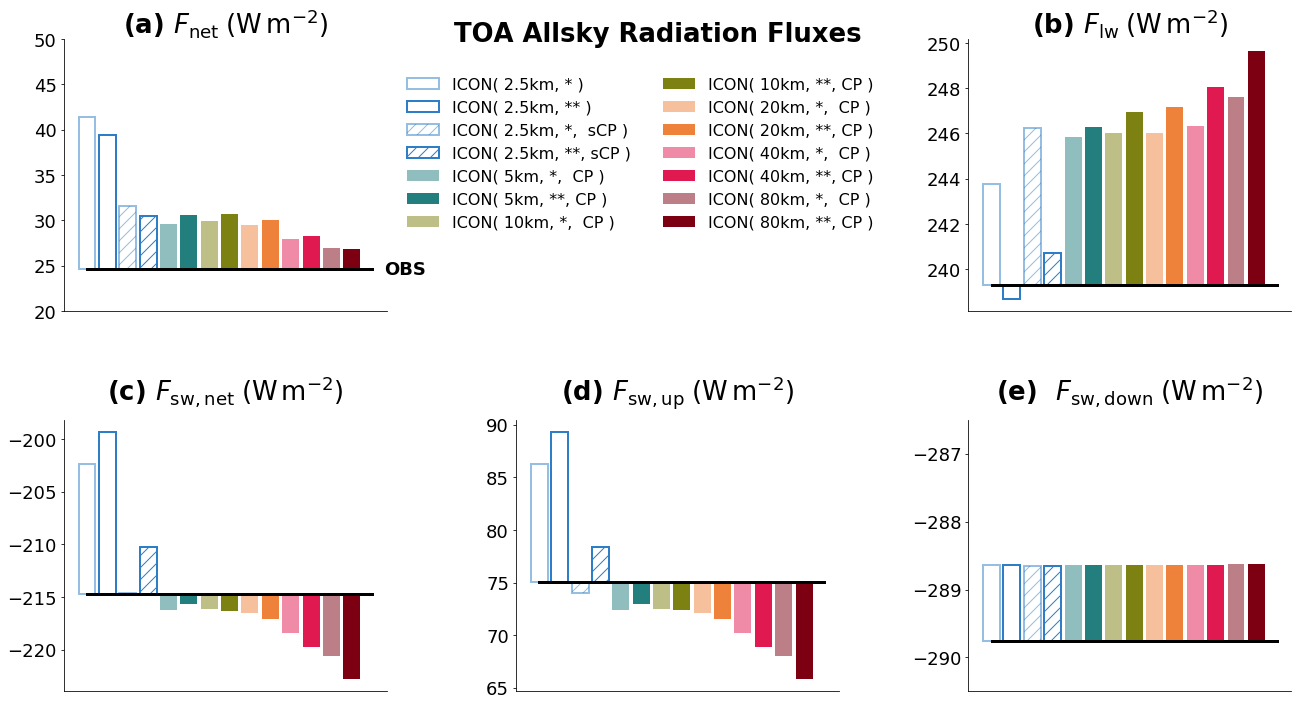

In [12]:
fig, ax = pl.subplots(ncols = 3, nrows = 2, figsize = (22,12))
ax = ax.flatten()




pl.sca(ax[0])
hor_barplot_exp_plot( dset, 'fnet', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
fkws = dict( fontweight = 'bold', fontsize = 'x-large' )
pl.title('(a) $F_\mathrm{net}\; (\mathrm{W\,m^{-2}})$',**fkws)
pl.ylim(20,50)
pl.text(0.33, 24, 'OBS', fontweight = 'bold')
#pl.legend(loc = 'center right', bbox_to_anchor = (2.3, 0.5), frameon = False)
plegend(loc = 'center right', bbox_to_anchor = (2.55, 0.58), frameon = False, ncol = 2, fontsize = 16)

a = ax[1]
a.axis('off')

pl.sca(ax[2])
hor_barplot_exp_plot( dset, 'lwf', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(b) $F_\mathrm{lw}\; (\mathrm{W\,m^{-2}})$', **fkws )


pl.sca(ax[3])
hor_barplot_exp_plot( dset, 'swf_net', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
fkws['pad'] = 20
pl.title('(c) $F_\mathrm{sw, net}\; (\mathrm{W\,m^{-2}})$', **fkws)

pl.sca(ax[4])
hor_barplot_exp_plot( dset, 'swf_up', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(d) $F_\mathrm{sw, up}\; (\mathrm{W\,m^{-2}})$', **fkws)
         
pl.sca(ax[5])
hor_barplot_exp_plot( dset, 'swf_down', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(e)  $F_\mathrm{sw, down}\; (\mathrm{W\,m^{-2}})$', **fkws)
pl.ylim(-290.5, -286.5)
pl.yticks([-287, -288, -289, -290])
sns.despine()
pl.subplots_adjust(wspace = 0.4, hspace = 0.4)
pl.suptitle('TOA Allsky Radiation Fluxes', fontsize = 'x-large', fontweight = 'bold', y = 0.9)
pl.savefig('../pics/domain_average_radfluxes_allsets.png', dpi = 100)

## Plot fluxes only for set 2

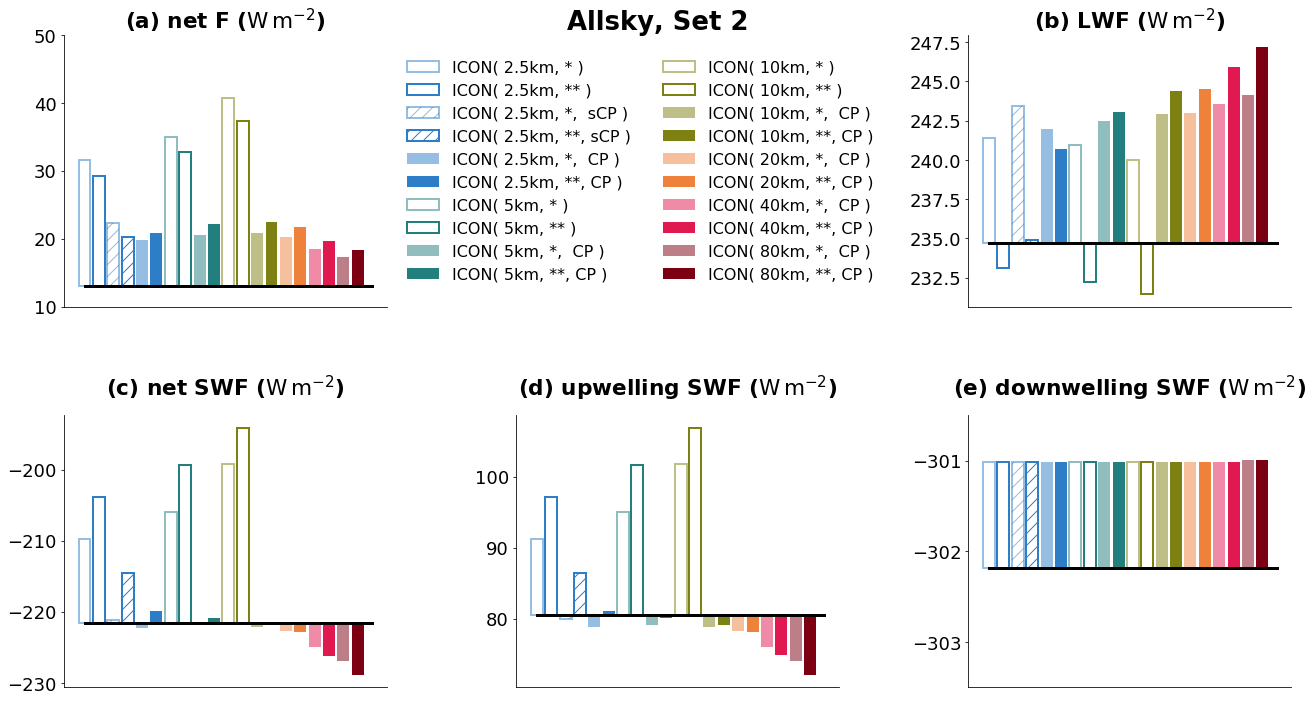

In [15]:
dset2 = domaveflux( rset2 )

fig, ax = pl.subplots(ncols = 3, nrows = 2, figsize = (22,12))
ax = ax.flatten()



pl.sca(ax[0])
hor_barplot_exp_plot( dset2, 'fnet', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(a) net F ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold')
pl.ylim(10,50)

plegend(loc = 'center right', bbox_to_anchor = (2.55, 0.5), frameon = False, ncol = 2, fontsize = 16)

#pl.legend(loc = 'center right', bbox_to_anchor = (2.55, 0.5), frameon = False, ncol = 2, fontsize = 'small')

a = ax[1]
a.axis('off')

pl.sca(ax[2])
hor_barplot_exp_plot( dset2, 'lwf', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(b) LWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold')


pl.sca(ax[3])
hor_barplot_exp_plot( dset2, 'swf_net', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(c) net SWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold', pad = 20)

pl.sca(ax[4])
hor_barplot_exp_plot( dset2, 'swf_up', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(d) upwelling SWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold', pad = 20)
         
pl.sca(ax[5])
hor_barplot_exp_plot( dset2, 'swf_down', catlist = ['full', ], icount0 = 0)
pl.xticks([],[])
pl.title('(e) downwelling SWF ($\mathrm{W\,m^{-2}}$)', fontweight = 'bold', pad = 20)

pl.ylim(-303.5, -300.5)
pl.yticks([-303, -302, -301])
sns.despine()
pl.subplots_adjust(wspace = 0.4, hspace = 0.4)
pl.suptitle('Allsky, Set 2', fontsize = 'x-large', fontweight = 'bold', y = 0.91)

pl.savefig('../pics/domain_average_radfluxes_set2.png', dpi = 100)